In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%matplotlib inline
import sys,os
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.cm import get_cmap
import pandas as pd
from netCDF4 import Dataset
import xarray

In [3]:
sys.path.append('/home/equon/a2e-mmc')
from mmctools.wrf import utils as wrfutils

In [4]:
datadir = '/projects/mmc/SWIFTRegion/8Nov2013/WRFrun'
prefix = 'wrfout_d03_'

In [5]:
# from google maps
tower_coords = (33.61054, -102.05055)

In [6]:
# Jeff's identified convective period
timerange = pd.date_range(start='2013-11-08 17:00',end='2013-11-08 23:00',freq='1h')
tfmt = '%Y-%m-%d_%H:%M:%S'

In [7]:
%%time
Uprofiles = []
Vprofiles = []
Wprofiles = []
Tprofiles = []
times = []
zhist = []
for hour in timerange:
    fname = os.path.join(datadir, prefix+hour.strftime(tfmt))
    print(hour,fname)
    #xa = Dataset(fname)
    xa = xarray.open_dataset(fname)
    tlist = wrfutils.wrf_times_to_datetime(xa)
    print(pd.DatetimeIndex(tlist))
    i,j = wrfutils.latlon_to_ij(xa,*tower_coords)
    z,zs = wrfutils.get_height_at_ind(xa,j,i)
    times += tlist
    zhist.append(z)
    Uprofiles.append(xa.variables['U'][:,:,j,i])
    Vprofiles.append(xa.variables['V'][:,:,j,i])
    Wprofiles.append(wrfutils.unstagger2d(xa.variables['W'][:,:,j,i],axis=1))
    Tprofiles.append(xa.variables['T'][:,:,j,i])
times = np.array(times)

2013-11-08 17:00:00 /projects/mmc/SWIFTRegion/8Nov2013/WRFrun/wrfout_d03_2013-11-08_17:00:00
DatetimeIndex(['2013-11-08 17:00:00', '2013-11-08 17:10:00',
               '2013-11-08 17:20:00', '2013-11-08 17:30:00',
               '2013-11-08 17:40:00', '2013-11-08 17:50:00'],
              dtype='datetime64[ns]', freq=None)
2013-11-08 18:00:00 /projects/mmc/SWIFTRegion/8Nov2013/WRFrun/wrfout_d03_2013-11-08_18:00:00
DatetimeIndex(['2013-11-08 18:00:00', '2013-11-08 18:10:00',
               '2013-11-08 18:20:00', '2013-11-08 18:30:00',
               '2013-11-08 18:40:00', '2013-11-08 18:50:00'],
              dtype='datetime64[ns]', freq=None)
2013-11-08 19:00:00 /projects/mmc/SWIFTRegion/8Nov2013/WRFrun/wrfout_d03_2013-11-08_19:00:00
DatetimeIndex(['2013-11-08 19:00:00', '2013-11-08 19:10:00',
               '2013-11-08 19:20:00', '2013-11-08 19:30:00',
               '2013-11-08 19:40:00', '2013-11-08 19:50:00'],
              dtype='datetime64[ns]', freq=None)
2013-11-08 20:00:00 /p

In [8]:
Nt,Nz,Ny,Nx = wrfutils.get_wrf_dims(xa)

In [9]:
tt = np.repeat(times[:,np.newaxis],Nz,axis=1)
zz = np.concatenate(zhist,axis=0)
U = np.concatenate(Uprofiles,axis=0)
V = np.concatenate(Vprofiles,axis=0)
W = np.concatenate(Wprofiles,axis=0)
T = np.concatenate(Tprofiles,axis=0) + 300.
tt.shape,zz.shape,U.shape,V.shape,W.shape

((42, 87), (42, 87), (42, 87), (42, 87), (42, 87))

Text(0,0.5,'height AGL [m]')

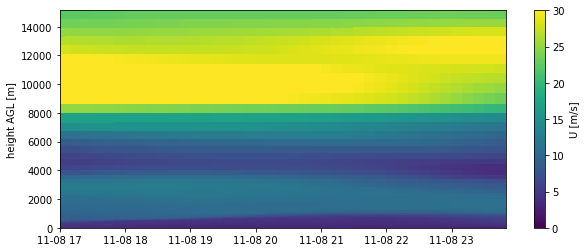

In [10]:
fig,ax = plt.subplots(figsize=(10,4))
cm = ax.pcolormesh(tt,zz,U,vmin=0,vmax=30)
fig.colorbar(cm,ax=ax,label='U [m/s]')
ax.set_ylabel('height AGL [m]')

0 2013-11-08 17:00:00
6 2013-11-08 18:00:00
12 2013-11-08 19:00:00
18 2013-11-08 20:00:00
24 2013-11-08 21:00:00
30 2013-11-08 22:00:00
36 2013-11-08 23:00:00


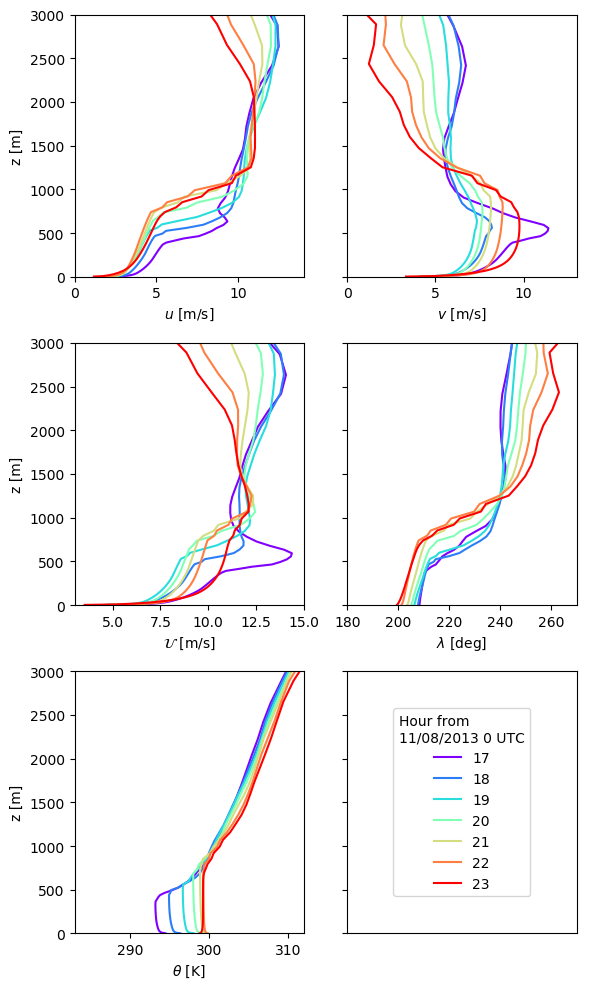

In [11]:
# Jeff's convective period
fig,ax = plt.subplots(nrows=3,ncols=2,sharey=True,figsize=(6,10),dpi=100)
cm = get_cmap('rainbow')
scale = np.arange(len(timerange))
scale = scale / scale[-1]
for snapshot,color in zip(timerange,cm(scale)):
    wspd = np.sqrt(U**2 + V**2 + W**2)
    wdir = np.degrees(np.arctan2(-U,-V))
    wdir[wdir < 0] += 360
    itime = np.where(times==snapshot)[0][0]
    print(itime,snapshot)
    ax[0,0].plot(U[itime,:],zz[itime,:],color=color,label=snapshot.hour)
    ax[0,1].plot(V[itime,:],zz[itime,:],color=color,label=snapshot.hour)
    ax[1,0].plot(wspd[itime,:],zz[itime,:],color=color,label=snapshot.hour)
    ax[1,1].plot(wdir[itime,:],zz[itime,:],color=color,label=snapshot.hour)
    ax[2,0].plot(T[itime,:],zz[itime,:],color=color,label=snapshot.hour)
ax[0,0].set_xlim((0,14))
ax[0,0].set_xlabel(r'$u$ [m/s]')
ax[0,1].set_xlim((0,13))
ax[0,1].set_xlabel(r'$v$ [m/s]')
ax[1,0].set_xlim((3,15))
ax[1,0].set_xlabel(r'$\mathcal{U}$ [m/s]')
ax[1,1].set_xlim((180,270))
ax[1,1].set_xlabel(r'$\lambda$ [deg]')
ax[2,0].set_xlim((283,312))
ax[2,0].set_xlabel(r'$\theta$ [K]')
ax[0,0].set_ylim((0,3000))
ax[0,0].set_ylabel('z [m]')
ax[1,0].set_ylabel('z [m]')
ax[2,0].set_ylabel('z [m]')
ax[2,1].set_xticks([])
ax[2,1].legend(ax[0,0].get_lines(),[tstr.hour for tstr in timerange],
               loc='center',
               title='Hour from\n11/08/2013 0 UTC')
fig.tight_layout()